# Проект: Мастерская-2. Мэтчинг.

**Описание исследования**

В этом исследовании предстоит найти максимально близкие (похожие) запросам товары из базы.

**Цель исследования**

Ознакомиться с библиотекой Faiss для эффективного поиска сходства и кластеризации векторов.

**Задача исследования**

Протестировать алгоритсы IVF, HNSV и разработать модель которая будет искать максимально близкие (похожие) запросам товары из базы. <br>Разработать решение на малом наборе данных и применить на большом.<br>

**Целевая метрика**

accuracy@k >= 70%<br>
k=5

**Исходные данные**

В распоряжении 4 датасета:<br>
- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base и т.д.) и вектор признаков размерностью 72.
- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query и т.д.), вектор признаков и id товара из base.csv который максимально похож на него (по мнению экспертов).
- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv.
- validation_answer.csv - правильные ответы к validation.csv.
  
Набор указанных датасетов представлен в двух вариантах - полном и сокращённом.<br> Полный набор включает в себя:<br>
base.csv из 2918139 строк,<br>
train.csv, validation.csv, validation_answer.csv каждый из 100000 строк.<br>
Сокращённый набор включает в себя:<br>
base.csv из 291813 строк,<br>
train.csv из 9999 строк,<br>
validation.csv и validation_answer.csv из 10000 строк  каждый.<br>

**План работы**<br>
- Загрузка и знакомство с данными сокращённого набора<br>
- Предобработка данных<br>
- Исследовательский и корреляционный анализ<br>
- Подготовка признаков<br>
- Разработка и тестирование модели<br>
- Загрузка и знакомство с данными полного датасета<br>
- Подготовка признаков<br>
- Тестирование модели


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


Будет применена FAISS для CPU

In [3]:
!apt install libomp-dev -q
!pip install faiss-cpu --no-cache -q
!pip install phik -q

Reading package lists...
Building dependency tree...
Reading state information...
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Импорты

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import faiss
import phik
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)

RANDOM_STATE = 123

## Загрузка и знакомство с данными

В первой части исследования работа будет проведена с сокращёнными датасетами. Загрузка полного датасета будет проведена во второй части для экономии ресурсов.

In [5]:
df, train, valid, valid_answer = (
pd.read_csv('base_small.csv', index_col=0), # набор товаров
pd.read_csv('train_small.csv', index_col=0), # тренировочный датасет
pd.read_csv('validation_small.csv', index_col=0), # валидационный датасет
pd.read_csv('validation_answer_small.csv', index_col=0)
                            # правильные ответы к валидационному датасету
)

Большие датасеты в тетрадь не загружаются из-за уведомления сервиса Google о невозможности проведения проверки на вирусы.<br>
Прямые ссылки на google drive<br>
df - https://drive.google.com/uc?export=download&id=1genXvyqt_7iFX3xNmgr6r1KTmsnnFkKE # набор товаров<br>
train - https://drive.google.com/uc?export=download&id=1L1JvjureaJUDfQukjQVX-IuKiAmpcTH7 # тренировочный датасет<br>
valid - https://drive.google.com/uc?export=download&id=1CwoqzuZiPp9ITKSE1RwCjm7EqdEt48cs # валидационный датасет<br>
valid_answer - https://drive.google.com/uc?export=download&id=1v29U6BR20MUwBJ_0TgguIz5fpe6QT4Q6 # правильные ответы к валидационному датасету<br>


In [6]:
def preview(list):
    for i in list:
        print([x for x in globals() if globals()[x] is i][0])
        print('======================================')
        display(i.head())
        print(i.info())
        print()

In [7]:
df_list = [df, train, valid, valid_answer]

In [8]:
preview(df_list)

df


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146


<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291813 non-null  float64
 21 

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base


<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21  21      9999 non-null   

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,108.809586,...,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,95.231290,...,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,59.321335,...,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,201.146090,...,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,131.900620,...,-116.440605,47.279976,-162.65400,107.409409,67.78526,-60.976490,142.68571,82.264300,-345.340457,-48.572525


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null 

,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB
None



Пропусков нет. Потребуется привести названия столбцов к snake_case.

In [9]:
for i in df_list:
  i.index.name = i.index.name.lower()
  i.columns = i.columns.str.lower()

In [10]:
for i in df_list:
    display(i.head(1))

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.06442,-4.069252,-340.63086,-57.55014,128.39822,45.090958,...,-71.92717,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,...,-24.60167,-167.76077,133.678516,68.1846,26.317545,11.938202,148.54932,-778.563381,-46.87775,66971-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.38342,8.563436,-28.203072,-134.22534,82.73661,-150.57217,-129.178969,23.670555,125.66636,108.809586,...,-103.48163,79.56453,-120.31357,54.218155,68.50073,32.681908,84.19686,136.41296,-1074.464888,-21.233612


,expected
id,
196680-query,1087368-base


In [11]:
for i in df_list:
    print([x for x in globals() if globals()[x] is i][0], 'dups', i.duplicated().sum())

df dups 11278
train dups 243
valid dups 265
valid_answer dups 360


Во всех датасетах обнаружены явные дубликаты. Они будут удалены из основного и обучающего датасетов. В валидационном датасете и ответах разное количество дубликатов, соответственно они расположены на разных позициях, поэтому их удаление нарушит структуру и не позволит правильно сопоставить id товаров и провести сверку ответов.

In [12]:
for i in df_list[:2]:
  print([x for x in globals() if globals()[x] is i][0], i.shape)
  print([x for x in globals() if globals()[x] is i][0], 'dups', i.duplicated().sum())
  i.drop_duplicates(inplace=True)
  print('dropping...')
  print([x for x in globals() if globals()[x] is i][0], i.shape)
  print()

df (291813, 72)
df dups 11278
dropping...
df (280535, 72)

train (9999, 73)
train dups 243
dropping...
train (9756, 73)



**Вывод**<br>
Проведено знакомоство с данными. Названия столбцов приведены к snake_case. Удалены явные дубликаты из основного и тренировочного датасетов.

## Исследовательский анализ данных

Посмотрим общую гистограмму на случайной выборке в 5000 строк

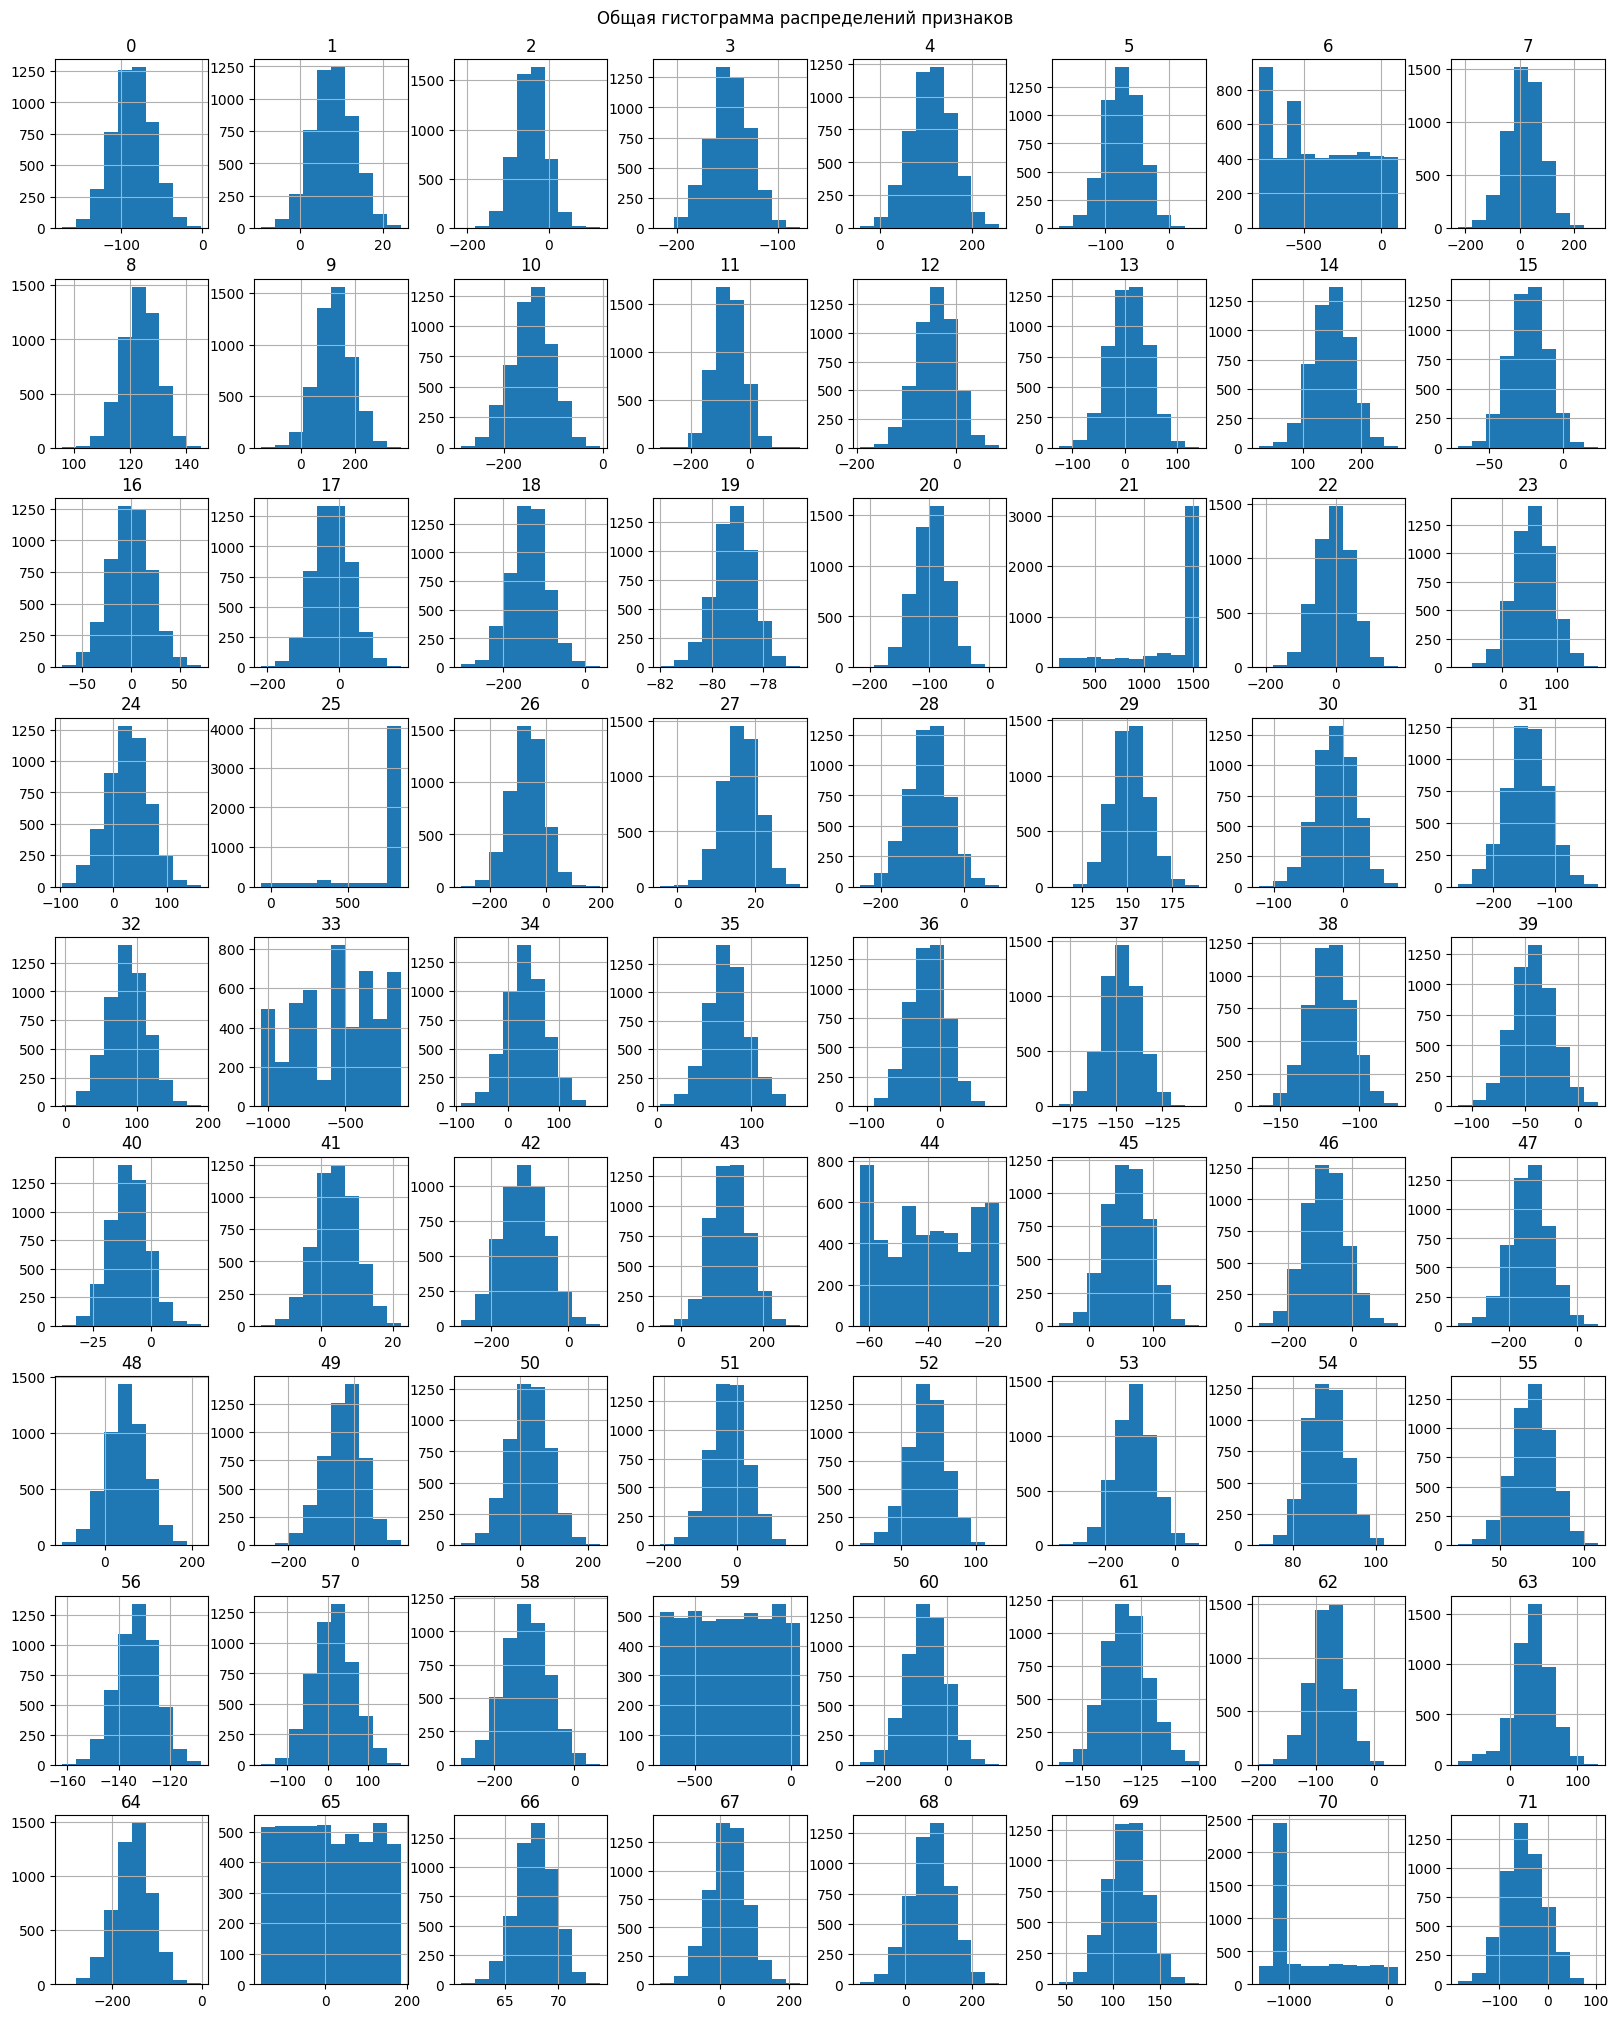

In [13]:
ax = df.sample(5000, random_state=RANDOM_STATE).hist(figsize=(20, 25))
plt.suptitle('Общая гистограмма распределений признаков', y=0.9);

In [14]:
#bx = train.sample(5000, random_state=RANDOM_STATE).hist(figsize=(20, 25))

Распределение большинства признаков похоже на нормальное со смещениями вправо/влево. Обнаружены признаки 6, 21, 25, 33, 44, 59, 65, 70 с ненормальным распределением. Они занесены в отдельный список. <br>
Распределение в тренировочном и валидационном датасетах аналогичное.

In [15]:
susp_list = [6, 21, 25, 33, 44, 59, 65, 70]

## Корреляционный анализ данных

In [16]:
interval_cols = train.select_dtypes(include=np.number).columns.to_list()

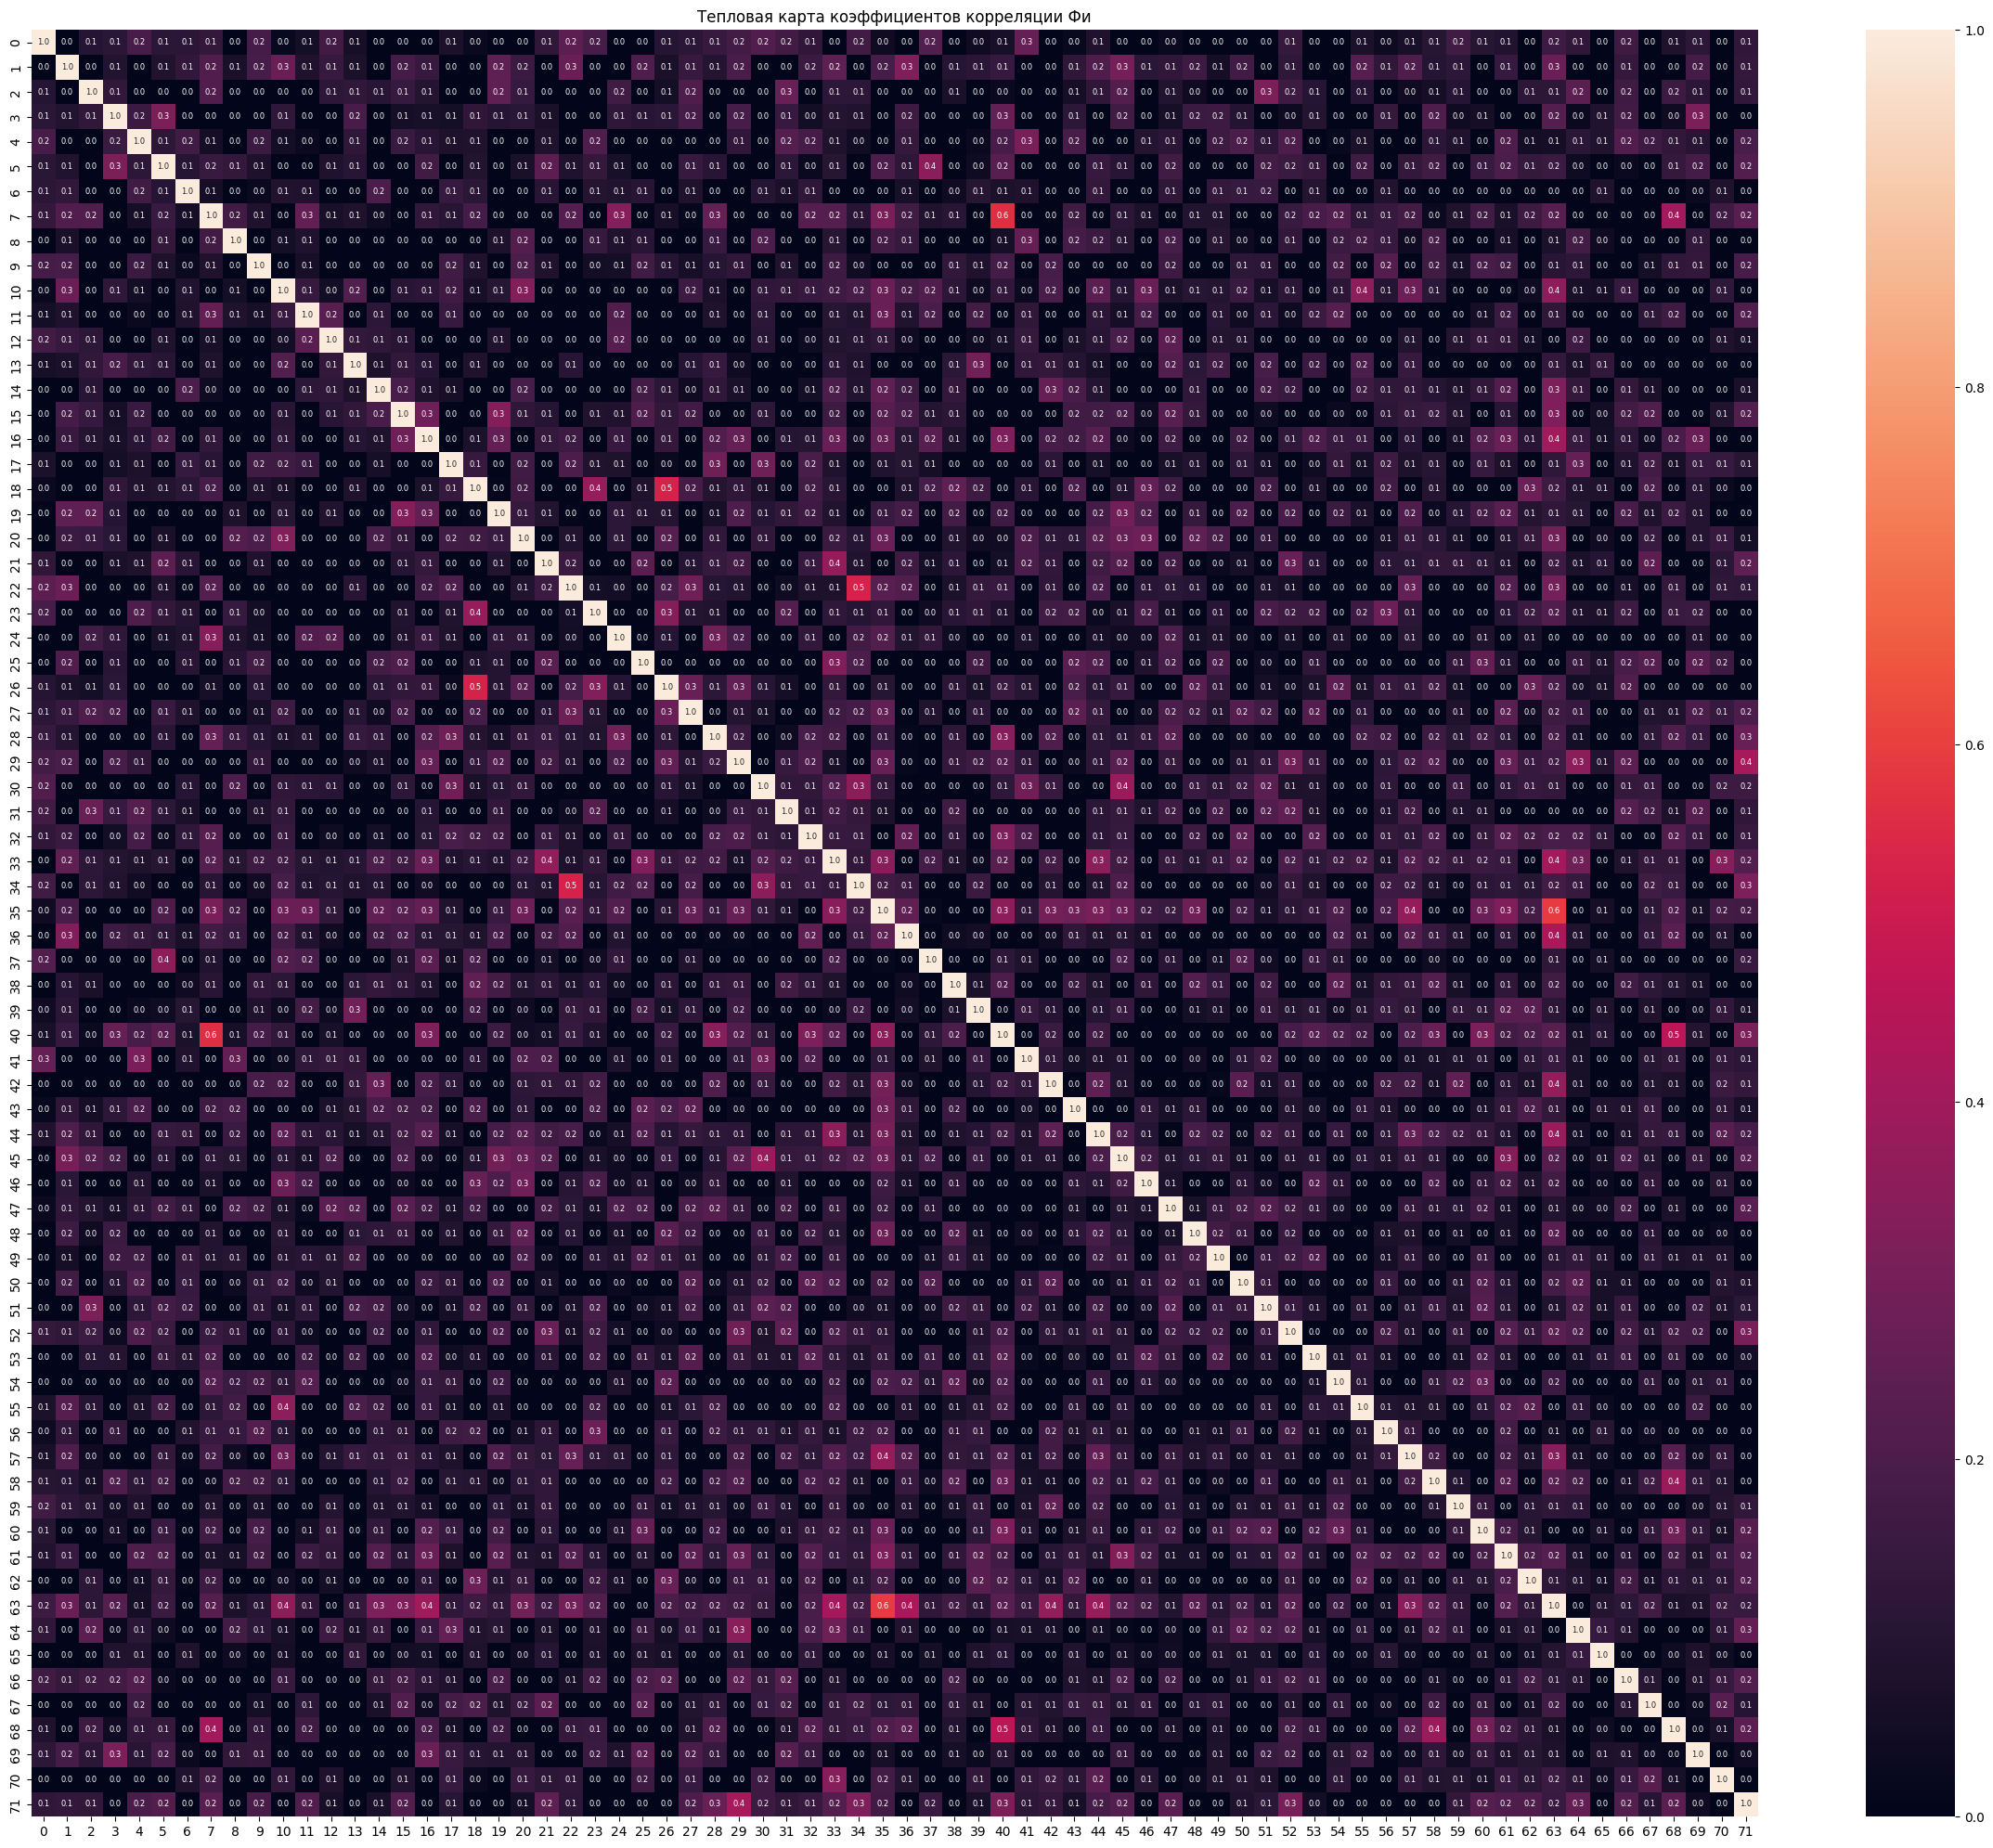

In [17]:
plt.figure(figsize=(30, 25))
sns.heatmap(df.sample(1000, random_state=RANDOM_STATE)
           .phik_matrix(interval_cols=interval_cols),
            annot=True, fmt='.1f', annot_kws={'fontsize':6})
plt.title('Тепловая карта коэффициентов корреляции Фи');

Мультиколлинеарность не наблюдается.

## Подготовка признаков

В результате экспериментов установлено, что удаление всех признаков, с распределением далёким от нормального, приводит к значительному росту метрики.

In [18]:
susp_list_str = []
for i in susp_list:
  susp_list_str.append(str(i))

In [19]:
for i in df_list[:3]:
    i.drop(susp_list_str, axis=1, inplace=True)

In [20]:
for i in df_list[:3]:
    print(i.shape[1])

64
65
64


В результате проведённых экспериментов масштабирование RobustScaler() показало лучшую метрику.

In [21]:
scaler = RobustScaler()
num_columns = train.select_dtypes(include=np.number).columns.to_list()
df[num_columns] = scaler.fit_transform(df[num_columns])
train[num_columns] = scaler.transform(train[num_columns])
valid[num_columns] = scaler.transform(valid[num_columns])

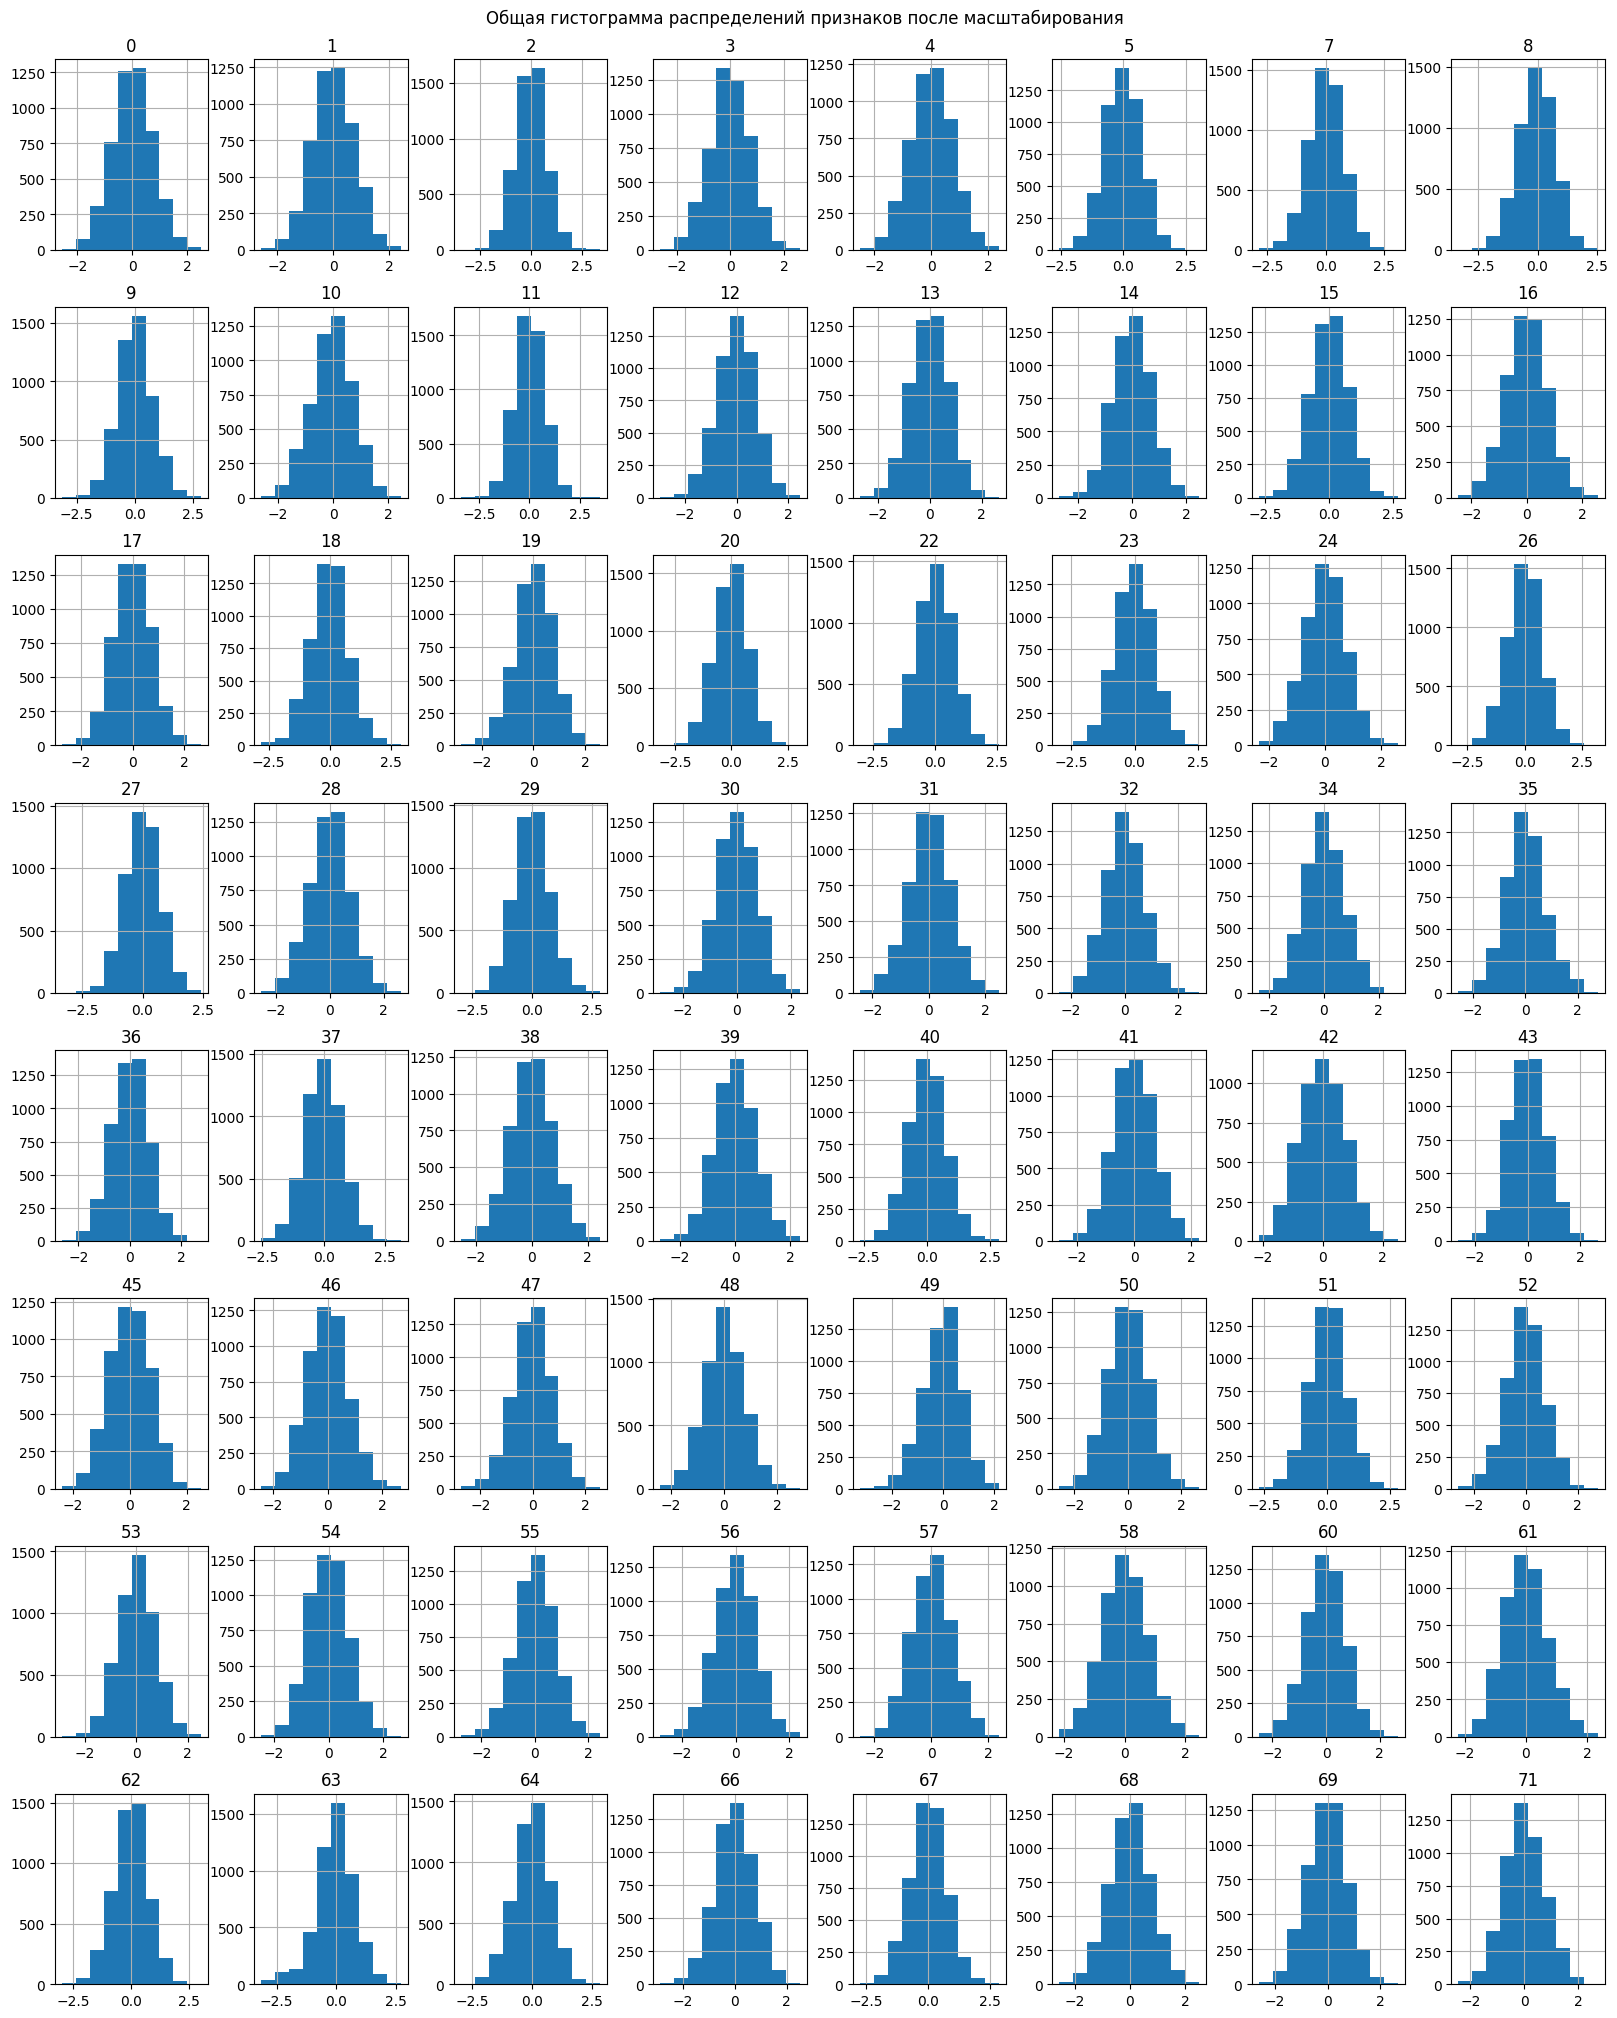

In [22]:
dx = df.sample(5000, random_state=RANDOM_STATE).hist(figsize=(20, 25))
plt.suptitle('Общая гистограмма распределений признаков после масштабирования',
                                                                        y=0.9);

## Разработка модели

### Inverted File Index, IVF

In [23]:
dims = df.shape[1]
n_cells = 15

In [24]:
idx_l2 = faiss.index_factory(dims, (f'IVF{n_cells}'+',Flat'))

In [25]:
%%time
idx_l2.train(np.ascontiguousarray(df.values).astype('float32'))

CPU times: user 156 ms, sys: 87 ms, total: 243 ms
Wall time: 234 ms


In [26]:
%%time
idx_l2.add(np.ascontiguousarray(df.values).astype('float32'))

CPU times: user 349 ms, sys: 188 ms, total: 537 ms
Wall time: 361 ms


In [27]:
base_index = {k: v for k, v in enumerate(df.index.to_list())}

In [28]:
targets = train['target']

In [29]:
train.drop('target', axis=1, inplace=True)

In [30]:
candidate_number = 5

In [31]:
idx_l2.nprobe = 6

In [32]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'),
                                                          candidate_number)

CPU times: user 1min 9s, sys: 157 ms, total: 1min 10s
Wall time: 45.6 s


#### Accuracy@5 на тренировочной выборке

In [33]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 78.5%


In [34]:
idx_IP = faiss.index_factory(dims, (f'IVF{n_cells}'+',Flat'),faiss.METRIC_INNER_PRODUCT)

In [35]:
idx_IP.train(np.ascontiguousarray(df.values).astype('float32'))

In [36]:
%%time
idx_IP.add(np.ascontiguousarray(df.values).astype('float32'))

CPU times: user 337 ms, sys: 251 ms, total: 588 ms
Wall time: 462 ms


In [37]:
idx_IP.nprobe = 6

In [38]:
%%time
r, idx = idx_IP.search(np.ascontiguousarray(train.values).astype('float32'),
                                                          candidate_number)

CPU times: user 57.7 s, sys: 115 ms, total: 57.8 s
Wall time: 35.2 s


In [39]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 76.1%


Косинусное расстояние показало хуже метрику

Accuracy @ 5 = 77.6% idx_IP.nprobe = 6 StandardScaler cosin<br>
Accuracy @ 5 = 77.9% idx_l2.nprobe = 6 MinMaxScaler euqlid<br>

Accuracy @ 5 = 78.4% n_cells = 15 idx_l2.nprobe = 6 StandardScaler euqlid<br>
Accuracy @ 5 = 78.5% n_cells = 15 idx_l2.nprobe = 6 RobustScaler euqlid Wall time: 47.1 s

Выводы<br>
Для алгоритма IVF на тренировочной выборке лучшая Accuracy @ 5 = 78.5% при n_cells = 15 nprobe = 6 RobustScaler с эвклидовым расстоянием

### HNSV

In [40]:
n_cells = 50
#n_cells = 75
ef_search = 32

In [41]:
%%time
idx_hnsv = faiss.index_factory(dims,
             (f'IVF{n_cells}_HNSW'+ f'{ef_search}'+',Flat'))

CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 4.85 ms


Используя функцию .index_factory() имеем:<br>
n_cells кластеров с центроидами. Центроиды кластеров хранятся в графе HNSW. Каждый центроид связан с ef_search другими центроидами.
Сами векторы не были изменены. Они являются Flat векторами.

Можно увеличить значение index.nprobe для поиска по большему количества кластеров - по умолчанию это значение равно 1. Мы можем увеличить значение nprobe для улучшения Recall (в ущерб скорости).

In [42]:
idx_hnsv.nprobe = 16
#idx_hnsv.nprobe = 6

In [43]:
idx_hnsv.train(np.ascontiguousarray(df.values).astype('float32'))

In [44]:
idx_hnsv.add(np.ascontiguousarray(df.values).astype('float32'))

In [45]:
%%time
r, idx = idx_hnsv.search(np.ascontiguousarray(train.values).astype('float32'),
                                                          candidate_number)

CPU times: user 50.8 s, sys: 121 ms, total: 50.9 s
Wall time: 31.7 s


#### Accuracy@5 на тренировочной выборке

In [46]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 78.5%


Accuracy @ 5 = 78.5% HNSV 50-32-16-Wall time: 31.3 s показало ту же метрику что и IVF, но отработала быстрее.

#### Accuracy@5 на валидационной выборке

In [47]:
%%time
r, idx = idx_hnsv.search(np.ascontiguousarray(valid.values).astype('float32'), candidate_number)

CPU times: user 50.7 s, sys: 115 ms, total: 50.8 s
Wall time: 32.4 s


In [48]:
acc = 0
for target, el in zip(valid_answer.expected.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 77.8%


Accuracy @ 5 = 77.8% idx_l2.nprobe = 6 StandardScaler euqlid n_cells = 15<br>
Accuracy @ 5 = 77.8% idx_l2.nprobe = 6 RobustScaler euqlid n_cells = 15 <br>


**ВЫВОДЫ**<br>
В финальном тестировании на сокращённом датасете побеждает алгоритм HNSV<br>
Accuracy @ 5 = 77.8%, nprobe = 16, RobustScaler, euqlid, n_cells = 50, Wall time: 31.7 s.

## Тест модели на полном датасете

In [49]:
# Удаляю ненужные переменные для освобождения ресурсов
del([df, train, valid, valid_answer, idx_l2, idx_hnsv, r, idx])


In [50]:
%%time
df, train, valid, valid_answer = (
pd.read_csv('base_full.csv', index_col=0), # набор товаров
pd.read_csv('train_full.csv', index_col=0), # тренировочный датасет
pd.read_csv('validation_full.csv', index_col=0), # валидационный датасет
pd.read_csv('validation_answer_full.csv', index_col=0) # правильные ответы к валидационному датасету
)

CPU times: user 1min 21s, sys: 9.45 s, total: 1min 31s
Wall time: 1min 44s


Прямые ссылки на google drive<br>
df - https://drive.google.com/uc?export=download&id=1XWVaO6IFCqdRUlstblNg0Na13kqpEMeh # набор товаров<br>
train - https://drive.google.com/uc?export=download&id=1afyNbiFboV_RqPhd0NKYJ5Ha4vbxV_x5 # тренировочный датасет<br>
valid - https://drive.google.com/uc?export=download&id=1xfvbnTB2BtcyLV0YjJS27Qft4Rwa5fVJ # валидационный датасет<br>
valid_answer - https://drive.google.com/uc?export=download&id=1lSaszYgnmkvdoAAMLBTKjcjMFxinVTXX # правильные ответы к валидационному датасету<br>

In [51]:
df_list = [df, train, valid, valid_answer]

In [52]:
preview(df_list)

df


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
None



In [53]:
for i in df_list:
    print([x for x in globals() if globals()[x] is i][0], 'dups', i.duplicated().sum())

i dups 0
i dups 0
i dups 0
i dups 8498


In [54]:
for i in df_list:
  i.index.name = i.index.name.lower()
  i.columns = i.columns.str.lower()

In [55]:
for i in df_list:
    display(i.head(1))

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.08389,11.152912,-64.42676,-118.88089,216.48244,-104.69806,-469.070588,44.348083,120.915344,181.4497,...,-42.808693,38.800827,-151.76218,-74.38909,63.66634,-4.703861,92.93361,115.26919,-112.75664,-60.830353


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,70.10736,-155.80257,-101.965943,65.90379,34.4575,62.642094,134.7636,-415.750254,-25.958572,675816-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.81572,112.88098,75.21575,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.07936


,expected
id,
100000-query,2676668-base


Пропуски в полных датасетах отсутствуют. Дубли только в ответах. Названия столбцов приведены к snake_case.

In [56]:
for i in df_list[:3]:
    i.drop(susp_list_str, axis=1, inplace=True)

In [57]:
for i in df_list[:3]:
    print(i.shape)

(2918139, 64)
(100000, 65)
(100000, 64)


In [58]:
df[num_columns] = scaler.fit_transform(df[num_columns])
train[num_columns] = scaler.transform(train[num_columns])
valid[num_columns] = scaler.transform(valid[num_columns])

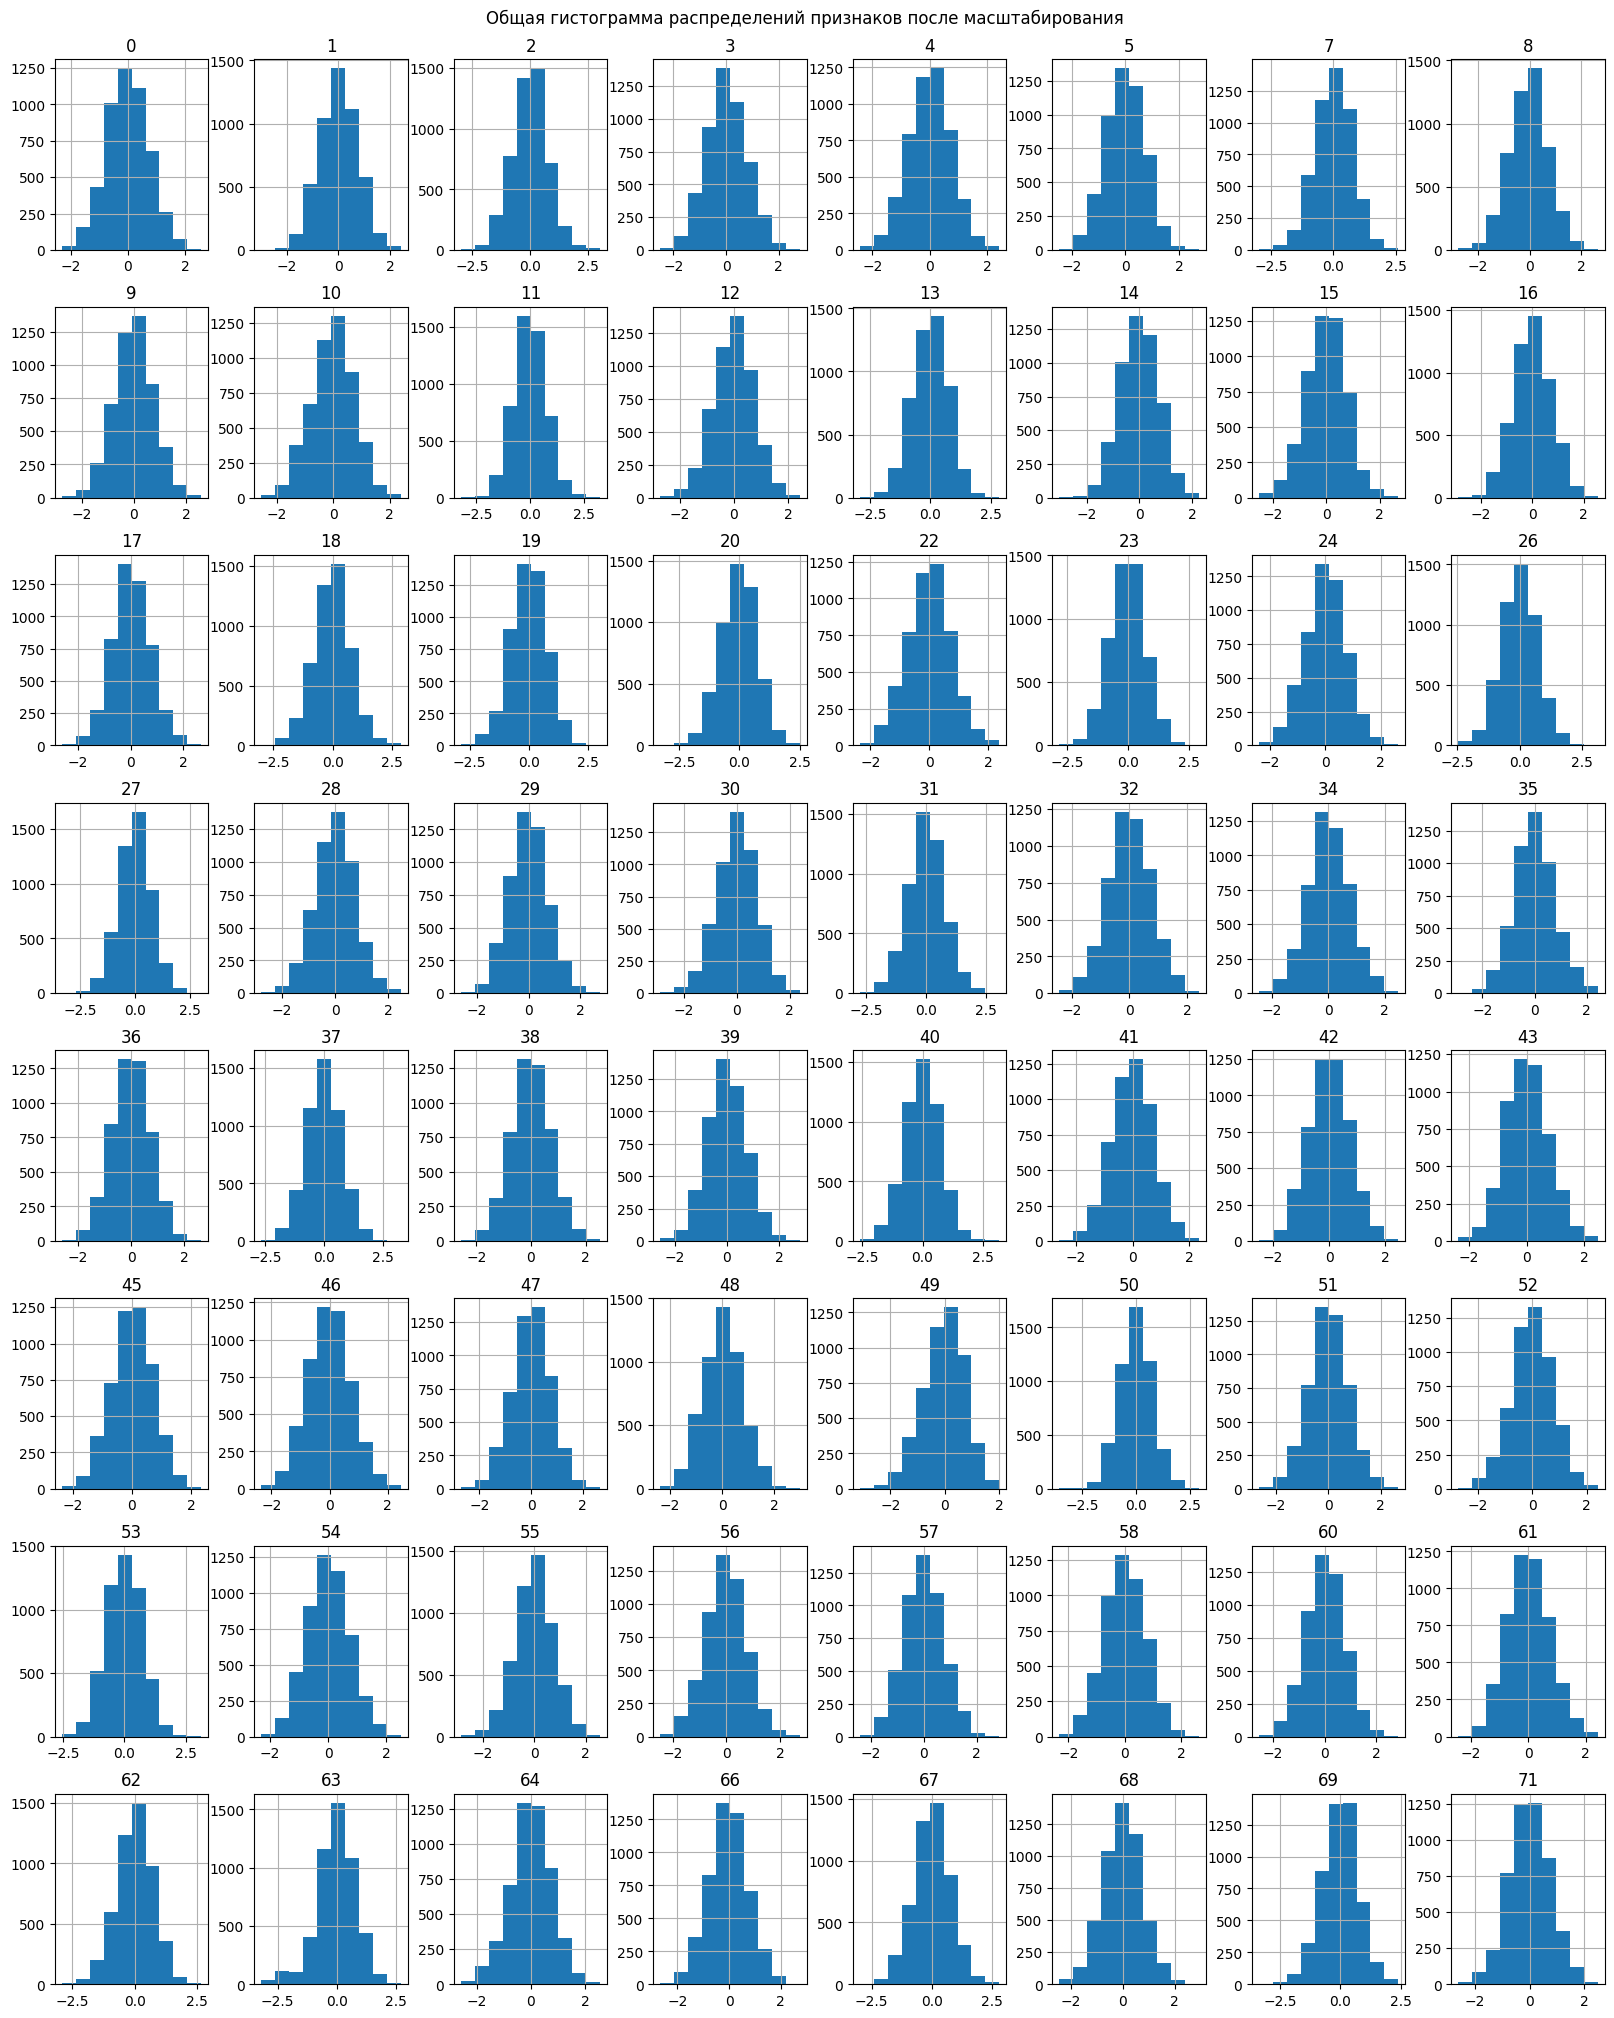

In [59]:
dx = df.sample(5000, random_state=RANDOM_STATE).hist(figsize=(20, 25))
plt.suptitle('Общая гистограмма распределений признаков после масштабирования',
                                                                        y=0.9);

In [60]:
n_cells

50

In [61]:
n_cells = 75

In [62]:
ef_search

32

In [63]:
%%time
idx_hnsv = faiss.index_factory(dims,
             (f'IVF{n_cells}_HNSW'+ f'{ef_search}'+',Flat'))

CPU times: user 5.16 ms, sys: 13 µs, total: 5.17 ms
Wall time: 8.25 ms


In [64]:
idx_hnsv.nprobe = 6
#idx_hnsv.nprobe = 16

In [65]:
base_index = {k: v for k, v in enumerate(df.index.to_list())}

In [66]:
targets = train['target']

In [67]:
train.drop('target', axis=1, inplace=True)

In [68]:
idx_hnsv.train(np.ascontiguousarray(df.values).astype('float32'))

In [69]:
%%time
idx_hnsv.add(np.ascontiguousarray(df.values).astype('float32'))

CPU times: user 32.6 s, sys: 1.83 s, total: 34.5 s
Wall time: 23.6 s


In [70]:
%%time
r, idx = idx_hnsv.search(np.ascontiguousarray(train.values).astype('float32'),
                                                          candidate_number)

CPU times: user 24min 43s, sys: 2.76 s, total: 24min 46s
Wall time: 15min 23s


#### Accuracy@5 на тренировочной выборке

In [71]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 70.1%


Accuracy @ 5 = 70.9% при nprobe = 16, n_cells = 50,
ef_search = 32, 48 min<br>
Accuracy @ 5 = 70.7% при nprobe = 16, n_cells = 100,
ef_search = 32, 29 min<br>
Accuracy @ 5 = 70.3% при nprobe = 6, n_cells = 50,
ef_search = 32, 18 min<br>
Accuracy @ 5 = 70.0% при nprobe = 6, n_cells = 100,
ef_search = 32, 11 min<br>
Accuracy @ 5 = 70.1% при nprobe = 5, n_cells = 50,
ef_search = 32, 15 min<br>
Accuracy @ 5 = 70.1% при nprobe = 6, n_cells = 75,
ef_search = 32, 15 min<br>
Ради увеличения метрики на 0.8% прирост времени ожидания в три раза, по моему мнению, нерационально.


#### Accuracy@5 на валидационной выборке

In [72]:
%%time
r, idx = idx_hnsv.search(np.ascontiguousarray(valid.values).astype('float32'),
                                                          candidate_number)

CPU times: user 24min 30s, sys: 2.92 s, total: 24min 33s
Wall time: 14min 55s


In [73]:
acc = 0
for target, el in zip(valid_answer.expected.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 70.0%


Wall time: 14min 55s Accuracy @ 5 = 70.0%

## Вывод<br>
В результате исследования разработана модель с использованием библиотеки FAISS и алгоритма HNSV которая находит 100000 похожих товаров (эмбеддинги с размерностью 72) в базе из 2918139 строк за ~15 минут с метрикой accuracy@5 = 70.0%.

Автор: Вадим Говтьян<br>
Telegram: https://t.me/Vadim_Hellwalker<br>
e_mail: v_ad@mail.ru<br>